In [1]:
import numpy as np

In [2]:
path = "sampled_scan_points/FaMoS_subject_001/anger/anger.000013.npy"
data = np.load(path, allow_pickle=True)

In [4]:
data.shape

(100000, 3)

In [5]:
import glob
import cv2 
import os
def images_to_video(folder_path, to_path_video, cam_id):
    img_arr = []
    img_paths = glob.glob(f'{folder_path}/*/*.{cam_id}.png')
    img_paths.sort(key = lambda x : os.path.split(x)[-1].split('.')[1])  # sort frames based on frame id asc
    for filename in img_paths:
        img = cv2.imread(filename)
        height, width, _ = img.shape
        size = (width, height)
        img_arr.append(img)
    print(f'there are {len(img_arr)} images under this folder')
    print(f'img size: h={size[1]}, w={size[0]}')
    
    out = cv2.VideoWriter(to_path_video,cv2.VideoWriter_fourcc(*'mp4v'), 30, size)
    for i in range(len(img_arr)):
        out.write(img_arr[i])
    out.release()

In [6]:
folder_path = 'downsampled_images_4/FaMoS_subject_001/mouth_extreme'
to_path_video = "test.mp4"
cam_id = "26_C"
images_to_video(folder_path, to_path_video, cam_id)

there are 40 images under this folder
img size: h=300, w=400


## test the landmark embedding's shape

### 68 landmarks

In [5]:
import numpy as np 
path = "/local/home/yaqqin/repos/face_animation/flame_2020/landmark_embedding.npy"
lmk_embeddings = np.load(path, allow_pickle=True, encoding='latin1')
lmk_embeddings = lmk_embeddings[()] 
lmk_embeddings['full_lmk_faces_idx'].shape

(1, 68)

In [6]:
lmk_embeddings['full_lmk_bary_coords'].shape

(1, 68, 3)

In [6]:
lmk_embeddings['static_lmk_faces_idx'].shape

(51,)

In [8]:
lmk_embeddings.keys()

dict_keys(['static_lmk_faces_idx', 'static_lmk_bary_coords', 'dynamic_lmk_faces_idx', 'dynamic_lmk_bary_coords', 'full_lmk_faces_idx', 'full_lmk_bary_coords'])

In [8]:
lmk_embeddings['dynamic_lmk_faces_idx'].shape

torch.Size([79, 17])

In [10]:
lmk_embeddings['dynamic_lmk_bary_coords'].shape

torch.Size([79, 17, 3])

### media pipe embeddings 105 landmarks

In [1]:
import numpy as np 
path = "flame_2020/mediapipe_landmark_embedding.npz"
lmk_embeddings = np.load(path)

In [2]:
lmk_embeddings.files

['lmk_face_idx', 'lmk_b_coords', 'landmark_indices']

In [3]:
landmark_indices = lmk_embeddings['landmark_indices']

In [4]:
landmark_indices

array([276, 282, 283, 285, 293, 295, 296, 300, 334, 336,  46,  52,  53,
        55,  63,  65,  66,  70, 105, 107, 249, 263, 362, 373, 374, 380,
       381, 382, 384, 385, 386, 387, 388, 390, 398, 466,   7,  33, 133,
       144, 145, 153, 154, 155, 157, 158, 159, 160, 161, 163, 173, 246,
       168,   6, 197, 195,   5,   4, 129,  98,  97,   2, 326, 327, 358,
         0,  13,  14,  17,  37,  39,  40,  61,  78,  80,  81,  82,  84,
        87,  88,  91,  95, 146, 178, 181, 185, 191, 267, 269, 270, 291,
       308, 310, 311, 312, 314, 317, 318, 321, 324, 375, 402, 405, 409,
       415])

In [24]:
lmk_embeddings["lmk_face_idx"].shape

(105,)

In [25]:
lmk_embeddings["lmk_b_coords"].shape

(105, 3)

### flame vertex mask

In [50]:
import pickle
import numpy as np 

flame_vmask_path = "flame_2020/FLAME_masks.pkl"
with open(flame_vmask_path, 'rb') as f:
    flame_v_mask = pickle.load(f, encoding="latin1")

In [49]:
flame_v_mask.keys()

dict_keys(['eye_region', 'neck', 'left_eyeball', 'right_eyeball', 'right_ear', 'right_eye_region', 'forehead', 'lips', 'nose', 'scalp', 'boundary', 'face', 'left_ear', 'left_eye_region'])

In [52]:
flame_v_mask['face']

array([  16,   17,   18, ..., 3926, 3927, 3928])

## test 68 3d keypoints location w.r.t. FLAME topology

In [28]:
import torch
from smpl_webuser.serialization import load_model
from psbody.mesh import Mesh
import numpy as np
import pyrender
import trimesh

def to_tensor(array, dtype=torch.float32):
    if 'torch.tensor' not in str(type(array)):
        return torch.tensor(array, dtype=dtype)
def to_np(array, dtype=np.float32):
    if 'scipy.sparse' in str(type(array)):
        array = array.todense()
    return np.array(array, dtype=dtype)

def vertices2landmarks(vertices, faces, lmk_faces_idx, lmk_bary_coords):
    ''' Calculates landmarks by barycentric interpolation

        Parameters
        ----------
        vertices: torch.tensor BxVx3, dtype = torch.float32
            The tensor of input vertices
        faces: torch.tensor Fx3, dtype = torch.long
            The faces of the mesh
        lmk_faces_idx: torch.tensor L, dtype = torch.long
            The tensor with the indices of the faces used to calculate the
            landmarks.
        lmk_bary_coords: torch.tensor Lx3, dtype = torch.float32
            The tensor of barycentric coordinates that are used to interpolate
            the landmarks

        Returns
        -------
        landmarks: torch.tensor BxLx3, dtype = torch.float32
            The coordinates of the landmarks for each mesh in the batch
    '''
    # Extract the indices of the vertices for each face
    # BxLx3
    batch_size, num_verts = vertices.shape[:2]

    lmk_faces = torch.index_select(faces, 0, lmk_faces_idx.view(-1)).view(
        batch_size, -1, 3)

    lmk_faces += torch.arange(
        batch_size, dtype=torch.long).view(-1, 1, 1) * num_verts

    lmk_vertices = vertices.view(-1, 3)[lmk_faces].view(
        batch_size, -1, 3, 3)
    landmarks = torch.einsum('blfi,blf->bli', [lmk_vertices, lmk_bary_coords])
    return landmarks

def select_3d68(vertices):
    # load the landmark embedding 
    path = "/local/home/yaqqin/repos/AGRoL/flame_2020/landmark_embedding.npy"
    lmk_embeddings = np.load(path, allow_pickle=True, encoding='latin1')
    lmk_embeddings = lmk_embeddings[()] 
    full_lmk_faces_idx = torch.from_numpy(lmk_embeddings['full_lmk_faces_idx']).long()
    full_lmk_bary_coords = torch.from_numpy(lmk_embeddings['full_lmk_bary_coords'])
    
    # load the flame model
    flame_model_fname = "/local/home/yaqqin/repos/AGRoL/flame_2020/generic_model.pkl"
    model = load_model(flame_model_fname)
    faces_tensor = to_tensor(to_np(model.f, dtype=np.int64), dtype=torch.long)
    landmarks3d = vertices2landmarks(vertices, faces_tensor,
                                    full_lmk_faces_idx.repeat(vertices.shape[0], 1),
                                    full_lmk_bary_coords.repeat(vertices.shape[0], 1, 1))
    return landmarks3d

def select_3d105(vertices):
    # load the landmark embedding 
    path = "flame_2020/mediapipe_landmark_embedding.npz"
    lmk_embeddings = np.load(path)
    lmk_faces_idx = to_tensor(
        np.array(lmk_embeddings['lmk_face_idx'], dtype=np.int64)
    ).long()
    lmk_bary_coords = to_tensor(lmk_embeddings['lmk_b_coords'])
    
    # load the flame model
    flame_model_fname = "/local/home/yaqqin/repos/AGRoL/flame_2020/generic_model.pkl"
    model = load_model(flame_model_fname)
    faces_tensor = to_tensor(to_np(model.f, dtype=np.int64), dtype=torch.long)
    landmarks3d = vertices2landmarks(vertices, faces_tensor,
                                    lmk_faces_idx.repeat(vertices.shape[0], 1),
                                    lmk_bary_coords.repeat(vertices.shape[0], 1, 1))
    return landmarks3d

def select_dense_lmk(vertices):
    # load the landmark embedding 
    path = "flame_2020/dense_lmk_embedding.npy"
    lmk_embeddings = np.load(path, allow_pickle=True, encoding='latin1')
    lmk_embeddings = lmk_embeddings[()] 
    full_lmk_faces_idx = torch.from_numpy(lmk_embeddings['full_lmk_faces_idx']).long()
    full_lmk_bary_coords = torch.from_numpy(lmk_embeddings['full_lmk_bary_coords'])
    
    # load the flame model
    flame_model_fname = "flame_2020/generic_model.pkl"
    model = load_model(flame_model_fname)
    faces_tensor = to_tensor(to_np(model.f, dtype=np.int64), dtype=torch.long)
    lmk_68 = vertices2landmarks(vertices, faces_tensor,
                                    full_lmk_faces_idx.repeat(vertices.shape[0], 1),
                                    full_lmk_bary_coords.repeat(vertices.shape[0], 1, 1))
    dense_lmk_verts_idx = torch.from_numpy(lmk_embeddings['dense_verts_idx']).long()
    additional_dense_lmks = torch.index_select(vertices, 1, dense_lmk_verts_idx.view(-1))
    lmk_3d = torch.concat((lmk_68, additional_dense_lmks), dim=1)
    return lmk_3d

def show_3d_lmk_on_mesh(mesh_path):
    mesh_obj = trimesh.load_mesh(mesh_path)
    V = mesh_obj.vertices.shape[0]
    vertices = to_tensor(to_np(mesh_obj.vertices)).reshape(-1, V, 3) # (bs, 5023, 3)
    landmarks3d = select_dense_lmk(vertices)[0] # (bs, 68, 3)
    print(f"shape of lmks {landmarks3d.shape}")
    
    cam = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.4141)
    camera_pose = np.array([[1.0, 0, 0.0, 0.00],
                            [0.0, 1.0, 0.0, 0.00],
                            [0.0, 0.0, 1.0, 0.4],
                            [0.0, 0.0, 0.0, 1.0]])

    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=3.0) # by default white light
    
    material = pyrender.material.MetallicRoughnessMaterial(
                alphaMode='BLEND',
                baseColorFactor= (144, 117, 87, 255),
                metallicFactor=0.8,
                roughnessFactor=0.8,
                wireframe=True,
                emissiveFactor= 0.3,
    )
    h, w = 640, 480
    r = pyrender.OffscreenRenderer(h, w)
    
    obj_mesh = trimesh.load_mesh(mesh_path, process=False)
    py_mesh = pyrender.Mesh.from_trimesh(obj_mesh, material=material)
    
    # render the 3d keypoints
    sm = trimesh.creation.uv_sphere(radius=0.0015)
    sm.visual.vertex_colors = [1.0, 0.0, 0.0]
    tfs = np.tile(np.eye(4), (len(landmarks3d), 1, 1))
    tfs[:,:3,3] = landmarks3d
    py_lmk_3d = pyrender.Mesh.from_trimesh(sm, poses = tfs)

    scene = pyrender.Scene(bg_color=[0, 0, 0, 255],                  # by default black
                            ambient_light=[.2, .2, .2])
    node = pyrender.Node(
        mesh=py_mesh,
        translation=[0, 0, 0]
    )
    lmk3d_node = pyrender.Node(
        mesh = py_lmk_3d
    )
    scene.add_node(node)
    scene.add_node(lmk3d_node)
    scene.add(cam, pose=camera_pose)
    scene.add(light, pose=camera_pose)
    pyrender.Viewer(scene)
    # color, _ = r.render(scene)   
    

## Test the FLAME model

In [79]:
from smpl_webuser.serialization import load_model 
flame_model_fname = "flame_2020/generic_model.pkl"
model = load_model(flame_model_fname)

In [81]:
model.trans

[0. 0. 0.]

In [1]:
import os 
os.listdir("dataset/FaMoS/registrations")

['FaMoS_subject_006',
 'FaMoS_subject_011',
 'FaMoS_subject_027',
 'FaMoS_subject_023',
 'FaMoS_subject_020',
 'FaMoS_subject_015',
 'FaMoS_subject_004',
 'FaMoS_subject_009',
 'FaMoS_subject_028',
 'FaMoS_subject_029',
 'FaMoS_subject_002',
 'FaMoS_subject_019',
 'FaMoS_subject_013',
 'FaMoS_subject_014',
 'FaMoS_subject_016',
 'FaMoS_subject_021',
 'FaMoS_subject_031',
 'FaMoS_subject_012',
 'FaMoS_subject_018',
 'FaMoS_subject_008',
 'FaMoS_subject_022',
 'FaMoS_subject_010',
 'FaMoS_subject_001',
 'FaMoS_subject_007',
 'FaMoS_subject_017',
 'FaMoS_subject_005',
 'FaMoS_subject_025',
 'FaMoS_subject_026',
 'FaMoS_subject_030',
 'FaMoS_subject_024',
 'FaMoS_subject_003']

In [87]:
test = {"i": 1}
np.save("test.npy", test)

In [9]:
test = np.load("dataset/FaMoS/flame_params/FaMoS_subject_001/cheeks_in.npy", allow_pickle=True)[()]

In [7]:
test.keys()

dict_keys(['flame_trans', 'flame_pose', 'flame_shape', 'flame_expr', 'flame_verts', 'frame_id'])

In [12]:
np.max(test['flame_expr'])

10.133134459611952

In [148]:
test['flame_verts'].shape

(2, 5023, 3)

In [13]:
test['flame_trans']

array([[ 0.00337166, -0.02818997,  0.03445457],
       [ 0.0034748 , -0.02819267,  0.03436417],
       [ 0.00350378, -0.02819827,  0.03433647],
       [ 0.0035258 , -0.02822179,  0.03429401],
       [ 0.0036096 , -0.02821004,  0.03430586],
       [ 0.00362246, -0.02815891,  0.03431584],
       [ 0.0036365 , -0.02814935,  0.03430892],
       [ 0.00366548, -0.02810556,  0.03432793],
       [ 0.00369579, -0.02808668,  0.03431506],
       [ 0.00367006, -0.02801787,  0.03432736],
       [ 0.00366831, -0.02799146,  0.03432175],
       [ 0.00358443, -0.02796721,  0.03432796],
       [ 0.00354867, -0.02794712,  0.03429538],
       [ 0.00358322, -0.02793699,  0.03425847],
       [ 0.00353089, -0.02789558,  0.03425869],
       [ 0.00354406, -0.0278862 ,  0.03424346],
       [ 0.00345027, -0.02785593,  0.03423217],
       [ 0.00350634, -0.02784638,  0.03420425],
       [ 0.00349425, -0.02782946,  0.03416765],
       [ 0.00353484, -0.02779788,  0.03412572],
       [ 0.00351254, -0.02777643,  0.034

In [151]:
test['flame_shape'][1]

array([-0.47198703,  0.89381058, -0.58947383, -0.61250216,  0.04132704,
        0.49717613,  1.00382946, -0.50257322, -0.08618634,  1.48059402,
        1.46440271,  1.67085143, -0.08107779, -0.90285869,  1.09136551,
       -0.14477644, -0.39412614, -0.60793816,  0.8651935 , -0.65610018,
        1.22248228,  1.31529145, -1.22559392, -0.548237  , -1.32145555,
        0.44939849, -1.46746682,  0.40550055, -0.68519476, -0.55299465,
       -0.54474092,  1.1412457 ,  0.33293212, -1.7348096 ,  0.22156333,
        0.92006412,  2.71635721, -0.77105845, -3.09907848,  0.53623682,
        2.86358646,  1.82199199,  0.44414864,  0.23009515, -0.94838899,
       -1.58405363,  1.00002421,  3.05036501,  0.10418545, -2.34790264,
       -0.21557536,  3.47195519,  0.79358028, -2.07322161,  1.73071469,
       -2.99732104,  1.39298936,  0.23658872,  0.73144707,  1.10937615,
       -1.99019151, -1.8855152 ,  0.99085255, -1.11670389, -0.74504725,
       -3.45852653,  2.55759988, -1.13270824,  1.76574817, -2.25

In [154]:
b = np.load("flame_test/FaMoS_subject_001/bareteeth.npy", allow_pickle=True)[()]
b['flame_trans']

array([[ 0.00469638, -0.02913704,  0.03575507],
       [ 0.00474904, -0.02913539,  0.03571428]])

# check the mesh sequence in the FaMoS datasets

In [55]:
import cv2
import numpy as np 
import glob 
import os
import trimesh
import ffmpeg
import gc
import argparse
import pyrender
import pickle
import pymeshlab as pmlab
import matplotlib
os.environ['PYOPENGL_PLATFORM'] = 'egl'

def render_single_mesh_sequence(seq_path):
    tmp_dir = 'renders'
    fps = 30
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    h, w = 640, 480

    cam = pyrender.PerspectiveCamera(yfov=np.pi / 3.0) 
    camera_pose = np.array([[1.0, 0, 0.0, 0.00],
                            [0.0, 1.0, 0.0, 0.00],
                            [0.0, 0.0, 1.0, 0.4],
                            [0.0, 0.0, 0.0, 1.0]])

    light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=3.0)
    
    material = pyrender.material.MetallicRoughnessMaterial(
                alphaMode='BLEND',
                baseColorFactor= (144, 117, 87, 255),
                metallicFactor=0.8,
                roughnessFactor=0.8,
                wireframe=True,
                emissiveFactor= 0.3,
    )

    r = pyrender.OffscreenRenderer(viewport_width=w, viewport_height=h)

    print("prcessing mesh sequence in ", seq_path)

    video_woA_path = os.path.join(tmp_dir, "render.mp4")
    video = cv2.VideoWriter(video_woA_path, fourcc, fps, (w, h))
    
    # frame_lists = os.listdir(seq_path)

    obj_paths = sorted(glob.glob(f'{seq_path}/*.ply'))
    
    for i, obj_path in enumerate(obj_paths):
        
        # frame_id = os.path.split(obj_path)[-1].split('.')[1]
        # if frame_id not in frame_lists:
        #     continue
        
        obj_mesh = trimesh.load_mesh(obj_path, process=False)
        
        py_mesh = pyrender.Mesh.from_trimesh(obj_mesh, material=material)

        scene = pyrender.Scene(bg_color=[0, 0, 0, 255],
                               ambient_light=[0.2, 0.2, 0.2])
        node = pyrender.Node(
            mesh=py_mesh,
            translation=[0, 0, 0]
        )
        scene.add_node(node)
        
        scene.add(cam, pose=camera_pose)
        scene.add(light, pose=camera_pose)
        color, _ = r.render(scene)   
        # output_frame = os.path.join(tmp_dir, f"frame_{i}.png")

        # cv2.imwrite(output_frame, color)
        # frame = cv2.imread(output_frame)
        video.write(color)

    video.release()
    gc.collect()


In [120]:
def images_to_video(folder_path, to_path_video):
    img_arr = []
    img_paths = sorted(glob.glob(f'{folder_path}/*/*.26_C.png'))
    size = (0, 0)
    for filename in img_paths:
        img = cv2.imread(filename)
        height, width, _ = img.shape
        size = (width, height)
        img_arr.append(img)
    print(f'there are {len(img_arr)} images under this folder')
    print(f'img size: h={size[1]}, w={size[0]}')
    
    out = cv2.VideoWriter(to_path_video,cv2.VideoWriter_fourcc(*'mp4v'), 30, size)
    for i in range(len(img_arr)):
        out.write(img_arr[i])
    out.release()

In [56]:
seq_path = 'dataset/FaMoS/registrations/FaMoS_subject_001/cheeks_in'
render_single_mesh_sequence(seq_path)

prcessing mesh sequence in  dataset/FaMoS/registrations/FaMoS_subject_001/cheeks_in


In [121]:
folder_path = 'dataset/FaMoS/downsampled_images_4/FaMoS_subject_001/cheeks_in'
to_path_video = 'renders/original_videos.mp4'
images_to_video(folder_path, to_path_video)

there are 40 images under this folder
img size: h=300, w=400


In [7]:
import os
expressions = []
for f in sorted(os.listdir("/local/home/yaqqin/repos/AGRoL/dataset/FaMoS/flame_params/FaMoS_subject_001")):
    expressions.append(f.split(".")[0])

In [13]:
import numpy as np
file = "dataset/FaMoS/flame_params/FaMoS_subject_004/wrinkle_nose.npy"
data = np.load(file, allow_pickle=True)[()]

In [15]:
data.keys()

dict_keys(['flame_trans', 'flame_pose', 'flame_shape', 'flame_expr', 'flame_verts', 'frame_id'])

In [115]:
import torch
import trimesh
from vedo import trimesh2vedo, Plotter, show

def error_heatmap(template_mesh, metrics, vertex_mask=None):
    """generate heatmap w.r.t. the metrics onto the template face mask

    Args:
        template_mesh: a trimesh obejct in FLAME toplogy
        metrics: per vertex metrics, (5023,)
    """
    
    if vertex_mask is not None:
        mask = np.array([False] * template_mesh.vertices.shape[0])
        mask[vertex_mask] = True
        face_mask = mask[template_mesh.faces].all(axis=1)
        template_mesh.update_faces(face_mask)
        
    vmesh = trimesh2vedo(template_mesh)
    vmesh.cmap("jet", metrics)
    vmesh.add_scalarbar()
            
    show(vmesh, offscreen=True, size=(680, 900)).save("heatmap.png")
    
    
verts_gt = torch.rand((5023, 100, 3))
verts_pred = torch.rand((5023, 100, 3))
full_vertex_pos_error = torch.mean(
        torch.norm(
            verts_gt - verts_pred,
            2,
            2
        ),
        dim=1
    )
flame_vmask_path = "flame_2020/FLAME_masks.pkl"
with open(flame_vmask_path, 'rb') as f:
    flame_v_mask = pickle.load(f, encoding="latin1")
vertex_mask = flame_v_mask["face"]
mesh_path = "flame_2020/template.ply"
template_mesh = trimesh.load_mesh(mesh_path)
error_heatmap(template_mesh, full_vertex_pos_error, vertex_mask)

In [102]:
template_mesh.faces.shape

(9976, 3)

In [92]:
vertex_mask.shape

(1787,)

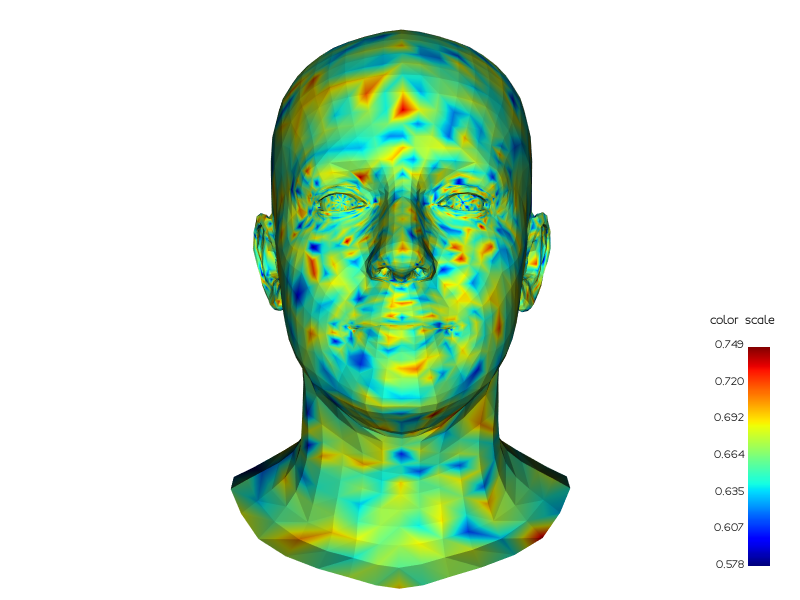

In [80]:

vmesh = trimesh2vedo(template_mesh)
vmesh.cmap("jet", full_vertex_pos_error)
vmesh.add_scalarbar(title="color scale")
show(vmesh, screenshot=False)

## select dense landmarks manually

In [14]:
import pymeshlab
import numpy as np
import pickle

In [19]:
def meshlab_2_vid(mesh_path="flame_2020/template_with_picked_points.ply"):   
    ms = pymeshlab.MeshSet()
    ms.load_new_mesh(mesh_path)
    mesh = ms.current_mesh()
    n_vertices = mesh.vertex_number()
    vmask = mesh.vertex_selection_array()
    vids_selected = np.array(range(n_vertices))[vmask]
    print(f"selected {vids_selected.shape} landmarks")
    return vids_selected

In [18]:
vids_dense_selected = meshlab_2_vid(mesh_path="flame_2020/template_with_picked_points.ply")
lmk_embeddings = np.load("flame_2020/landmark_embedding.npy", allow_pickle=True, encoding='latin1')
lmk_embeddings = lmk_embeddings[()] 

(108,)


In [20]:
lmk_embeddings.keys()

dict_keys(['static_lmk_faces_idx', 'static_lmk_bary_coords', 'dynamic_lmk_faces_idx', 'dynamic_lmk_bary_coords', 'full_lmk_faces_idx', 'full_lmk_bary_coords'])

In [21]:
lmk_embeddings['dense_verts_idx'] = vids_dense_selected

In [23]:
with open('flame_2020/dense_lmk_embedding.npy', 'wb') as f:
    np.save(f, lmk_embeddings)

In [24]:
dense_lmk_embeddings = np.load("flame_2020/dense_lmk_embedding.npy", allow_pickle=True, encoding='latin1')

### check data completeness

In [6]:
import os 
import numpy as np 
import glob 
from collections import defaultdict

data_dir = "dataset/FaMoS/flame_params"
logs = defaultdict(dict)
for sub in os.listdir(data_dir):
    if not sub.startswith("FaMoS"):
        continue  
    subject_id = sub[6:]
    all_seq = glob.glob(os.path.join(data_dir, sub, f"*.npy"))
    missing = 28 - len(all_seq)
    if missing > 0:
        logs[sub]["missing"] = missing 
    for file in all_seq:
        fitted_res = np.load(file, allow_pickle=True)[()]
        num_frames = len(fitted_res["flame_verts"])
        if num_frames == 0:
            expr = os.path.split(file)[-1][:-4]
            if "null" not in logs[sub]:
                logs[sub]["null"] = []
            logs[sub]["null"].append(expr)

In [7]:
logs

defaultdict(dict,
            {'FaMoS_subject_023': {'missing': 1},
             'FaMoS_subject_088': {'missing': 8},
             'FaMoS_subject_015': {'null': ['lip_corners_down']},
             'FaMoS_subject_036': {'missing': 1, 'null': ['mouth_side']},
             'FaMoS_subject_068': {'missing': 1},
             'FaMoS_subject_004': {'null': ['anger']},
             'FaMoS_subject_065': {'missing': 17},
             'FaMoS_subject_028': {'null': ['surprise']},
             'FaMoS_subject_041': {'null': ['rolling_lips',
               'head_rotation_up_down',
               'head_rotation_left_right']},
             'FaMoS_subject_083': {'missing': 8},
             'FaMoS_subject_039': {'missing': 6},
             'FaMoS_subject_091': {'null': ['head_rotation_up_down']},
             'FaMoS_subject_093': {'missing': 1},
             'FaMoS_subject_064': {'null': ['head_rotation_left_right']},
             'FaMoS_subject_076': {'missing': 1},
             'FaMoS_subject_016': {'mi

In [14]:
refit_sub = []
missing = 0
for sub in logs.keys():
    sid = int(sub.split("_")[-1])
    if sid < 71:
        refit_sub.append(sid)
        if "missing" in logs[sub]:
            missing += logs[sub]["missing"]
        if "null" in logs[sub]:
            missing += len(logs[sub]["null"])

In [12]:
refit_sub 

[23, 36, 68, 65, 39, 76, 16, 60, 44, 7, 25, 30, 69]

In [15]:
missing

95

In [4]:
import torch
def enc_dec_mask(T, S):
    mask = torch.ones(T, S)
    for i in range(T):
        mask[i, i] = 0
    return (mask==1)

In [5]:
T = 3 
S = 3 
enc_dec_mask(T, S)

tensor([[False,  True,  True],
        [ True, False,  True],
        [ True,  True, False]])

In [1]:
def enc_dec_mask(device, dataset, T, S):
    mask = torch.ones(T, S)
    if dataset == "BIWI":
        for i in range(T):
            mask[i, i*2:i*2+2] = 0
    elif dataset == "vocaset":
        for i in range(T):
            mask[i, i] = 0
    return (mask==1).to(device=device)


In [6]:
import torch
import math
enc_dec_mask("cpu", "vocaset", 3, 3)

tensor([[False,  True,  True],
        [ True, False,  True],
        [ True,  True, False]])

In [4]:
def _generate_subsequent_mask(tgt_sz, src_sz):
    mask = (torch.triu(torch.ones(src_sz, tgt_sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [5]:
_generate_subsequent_mask(tgt_sz=4, src_sz=3)

tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.],
        [0., 0., 0.]])

In [46]:
def init_biased_mask(target_size, weight_decay, bias_step):        
    bias = torch.arange(start=0, end=target_size, step=bias_step).unsqueeze(1).repeat(1,bias_step).view(-1) // (bias_step)
    bias_right = - bias[1:]
    bias_left = - torch.flip(bias,dims=[0])
    alibi = torch.zeros(target_size, target_size)
    for i in range(target_size):
        alibi[i, :i+1] = bias_left[-(i+1):]
        alibi[i, i+1:] = bias_right[:target_size-i-1]
    alibi = weight_decay * alibi
    
    return alibi

In [47]:
mask = init_biased_mask(target_size=6, weight_decay=0.25, bias_step=2)
mask.shape

tensor([ 0, -1, -1, -2, -2])
tensor([-2, -2, -1, -1,  0,  0])


torch.Size([6, 6])

In [48]:
mask

tensor([[ 0.0000,  0.0000, -0.2500, -0.2500, -0.5000, -0.5000],
        [ 0.0000,  0.0000,  0.0000, -0.2500, -0.2500, -0.5000],
        [-0.2500,  0.0000,  0.0000,  0.0000, -0.2500, -0.2500],
        [-0.2500, -0.2500,  0.0000,  0.0000,  0.0000, -0.2500],
        [-0.5000, -0.2500, -0.2500,  0.0000,  0.0000,  0.0000],
        [-0.5000, -0.5000, -0.2500, -0.2500,  0.0000,  0.0000]])

In [29]:
target_size = 6
bias_step = 2
bias = torch.arange(start=0, end=target_size, step=bias_step).unsqueeze(1).repeat(1,bias_step).view(-1) // (bias_step)
bias

tensor([0, 0, 1, 1, 2, 2])

In [30]:
bias = -torch.flip(bias, dims=[0])
bias

tensor([-2, -2, -1, -1,  0,  0])

In [24]:
def get_slopes(n):
    def get_slopes_power_of_2(n):
        start = (2**(-2**-(math.log2(n)-3)))
        ratio = start
        return [start*ratio**i for i in range(n)]
    if math.log2(n).is_integer():
        return get_slopes_power_of_2(n)                   
    else:                                                 
        closest_power_of_2 = 2**math.floor(math.log2(n)) 
        return get_slopes_power_of_2(closest_power_of_2) + get_slopes(2*closest_power_of_2)[0::2][:n-closest_power_of_2]

In [21]:
import librosa
from transformers import Wav2Vec2Processor
import numpy as np 

In [22]:
audio_processor = Wav2Vec2Processor.from_pretrained(
        "facebook/hubert-xlarge-ls960-ft")  # HuBERT uses the processor of Wav2Vec 2.0

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [24]:
audio_path = 'dataset/multiface/m--20171024--0000--002757580--GHS/audio/SEN_are_you_looking_for_employment.wav'
speech_array, sampling_rate = librosa.load(audio_path, sr=16000)
audio_values = np.squeeze(audio_processor(speech_array, return_tensors=None, padding="longest",
                            sampling_rate=sampling_rate).input_values)
print(audio_values.shape)
print(f"secs: {audio_values.shape[0] / sampling_rate}")
print(f"{type(audio_values)}")

(49600,)
secs: 3.1
<class 'numpy.ndarray'>


In [25]:
sampling_rate

16000

In [27]:
img_folder = 'dataset/multiface/m--20171024--0000--002757580--GHS/images/SEN_are_you_looking_for_employment/400016'
img_paths = glob(f'{img_folder}/*.png')
print(len(img_paths))

64


In [42]:
from torchvision import transforms
from glob import glob 
import cv2 
import numpy as np
from PIL import Image
import torch
import torchvision.transforms.functional as F 
import random

In [128]:
trans_order, b, c, s, h = transforms.ColorJitter.get_params(
    brightness=(0.5,1.5),
    contrast=(0.5, 1.5),
    saturation=(0.5,1.5),
    hue=(-0.1,0.1))


In [127]:
print(color_jitter)

(tensor([0, 1, 3, 2]), 0.520652711391449, 0.9065028429031372, 1.0351145267486572, 0.025928938761353493)


In [129]:
trans_order

tensor([3, 1, 0, 2])

In [27]:
img_folder = 'dataset/multiface/m--20171024--0000--002757580--GHS/images/SEN_are_you_looking_for_employment/400016'
img_paths = glob(f'{img_folder}/*.png')[:2]

In [30]:
img1 = Image.open(img_paths[0])
img2 = Image.open(img_paths[1])

In [133]:
transform = transforms.ColorJitter(
    brightness=(1, 2.5),
    contrast=(1, 2),
    saturation=(0),
    hue=(-0.1,0.1))


In [134]:
img1_trans = transform(img1)
print(transform.get_params)

<function ColorJitter.get_params at 0x7f67bc1fcf70>


In [135]:
img1_trans.show()

In [55]:
img2_trans.show()

In [43]:
#imgs of shape [N, 3, h, w]
def random_color_jitter(imgs, brightness, contrast, saturation, hue):
    vid_transforms = []
    if brightness is not None:
        vid_transforms.append(lambda img: F.adjust_brightness(img, brightness))
    if saturation is not None:
        vid_transforms.append(lambda img: F.adjust_saturation(img, saturation))
    if hue is not None:
        vid_transforms.append(lambda img: F.adjust_hue(img, hue))
    if contrast is not None:
        vid_transforms.append(lambda img: F.adjust_contrast(img, contrast))
    random.shuffle(vid_transforms)
    transform = transforms.Compose(vid_transforms)
    # for transform in vid_transforms:
    #     v = transform(v)

    return transform(imgs)

In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
img_path = 'dataset/vocaset/image/FaceTalk_170728_03272_TA/sentence03/sentence03.000004.26_C.jpg'

In [6]:
img = cv2.imread(img_path) / 255.